In [4]:
import os
os.listdir('/content')


['.config', 'sample_data']

Upload Files

In [6]:
import pandas as pd

train = pd.read_csv('/content/train.csv')
stores = pd.read_csv('/content/stores.csv')
oil = pd.read_csv('/content/oil.csv')
holidays = pd.read_csv('/content/holidays_events.csv')

print("Train shape:", train.shape)
train.head()



Train shape: (1084848, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


Convert Date to Proper Format

In [8]:
train['date'] = pd.to_datetime(train['date'])


Check Missing Values


In [9]:
train.isnull().sum()


,0
id,0
date,0
store_nbr,0
family,0
sales,1
onpromotion,1


Check Sales Values

In [10]:
(train['sales'] < 0).sum()


np.int64(0)

Remove Unwanted Columns

In [11]:
train = train.drop(columns=['id'])


Handle Missing Values

In [12]:
train['sales'] = train['sales'].fillna(0)
train['onpromotion'] = train['onpromotion'].fillna(0)


In [13]:
train.isnull().sum()


,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0


Create Time Features

In [14]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['dayofweek'] = train['date'].dt.dayofweek
train['weekofyear'] = train['date'].dt.isocalendar().week.astype(int)


In [15]:
train[['date','year','month','day','dayofweek','weekofyear']].head()


,date,year,month,day,dayofweek,weekofyear
0,2013-01-01,2013,1,1,1,1
1,2013-01-01,2013,1,1,1,1
2,2013-01-01,2013,1,1,1,1
3,2013-01-01,2013,1,1,1,1
4,2013-01-01,2013,1,1,1,1


Create Daily Sales Series

In [16]:
daily_sales = train.groupby('date')['sales'].sum().reset_index()
daily_sales.head()



,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


In [17]:
daily_sales.shape


(609, 2)

Prepare Data for Forecasting

In [18]:
daily_sales = daily_sales.sort_values('date')
daily_sales.set_index('date', inplace=True)


In [19]:
daily_sales.head()
daily_sales.tail()


,sales
date,
2014-08-29,403288.917062
2014-08-30,586373.694132
2014-08-31,660088.183052
2014-09-01,812526.219024
2014-09-02,526744.035057


Train-Test Split (Time Based)

In [20]:
split_date = daily_sales.index[-60]   # last 60 days for testing

train_ts = daily_sales[daily_sales.index < split_date]
test_ts = daily_sales[daily_sales.index >= split_date]

print("Train size:", train_ts.shape)
print("Test size:", test_ts.shape)


Train size: (549, 1)
Test size: (60, 1)


Simple Forecast Model (Moving Average Baseline)

In [21]:
train_ts['ma_7'] = train_ts['sales'].rolling(7).mean()
train_ts['ma_30'] = train_ts['sales'].rolling(30).mean()


/tmp/ipython-input-1821454476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ts['ma_7'] = train_ts['sales'].rolling(7).mean()
/tmp/ipython-input-1821454476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ts['ma_30'] = train_ts['sales'].rolling(30).mean()


In [22]:
last_30_avg = train_ts['sales'].tail(30).mean()
test_ts['pred_sales'] = last_30_avg


/tmp/ipython-input-715128931.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ts['pred_sales'] = last_30_avg


Evaluate

In [23]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_ts['sales'], test_ts['pred_sales'])
print("MAE:", mae)


MAE: 121595.58307238776


Visualize

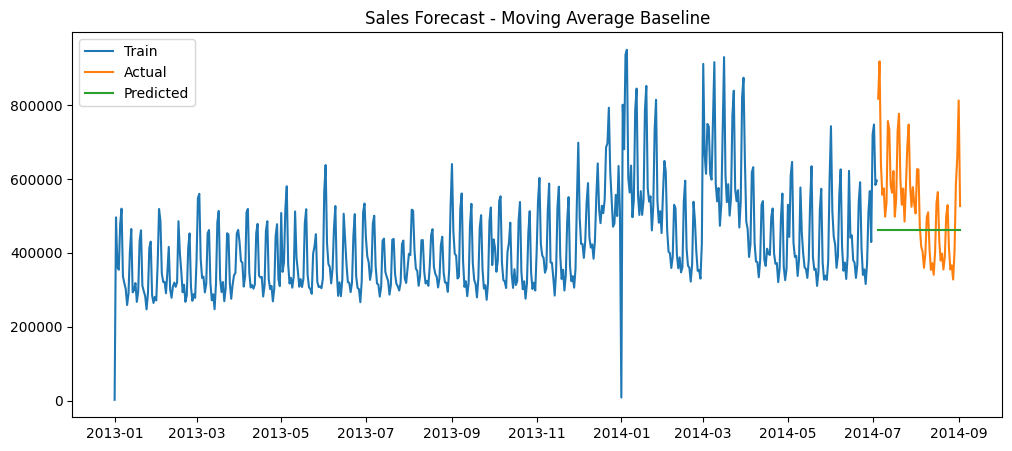

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train_ts.index, train_ts['sales'], label='Train')
plt.plot(test_ts.index, test_ts['sales'], label='Actual')
plt.plot(test_ts.index, test_ts['pred_sales'], label='Predicted')
plt.legend()
plt.title("Sales Forecast - Moving Average Baseline")
plt.show()


Build a Better ML Model (Regression with Time Features)

Prepare Dataset

In [25]:
# Merge daily sales with time features
daily_feat = daily_sales.reset_index()
daily_feat['year'] = daily_feat['date'].dt.year
daily_feat['month'] = daily_feat['date'].dt.month
daily_feat['day'] = daily_feat['date'].dt.day
daily_feat['dayofweek'] = daily_feat['date'].dt.dayofweek
daily_feat['weekofyear'] = daily_feat['date'].dt.isocalendar().week.astype(int)

X = daily_feat[['year','month','day','dayofweek','weekofyear']]
y = daily_feat['sales']


Time-based Split

In [26]:
split_index = len(daily_feat) - 60
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]


Train Model

In [27]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=42)

Predict


In [28]:
y_pred = model.predict(X_test)


Evaluate

In [29]:
from sklearn.metrics import mean_absolute_error
mae_rf = mean_absolute_error(y_test, y_pred)
print("Random Forest MAE:", mae_rf)


Random Forest MAE: 108582.46839001172


Plot

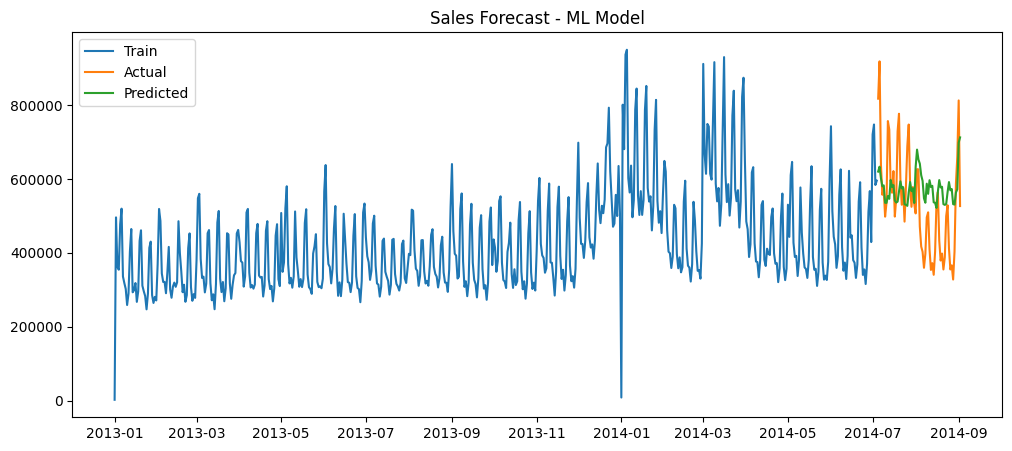

In [30]:
plt.figure(figsize=(12,5))
plt.plot(daily_feat['date'][:split_index], y_train, label='Train')
plt.plot(daily_feat['date'][split_index:], y_test, label='Actual')
plt.plot(daily_feat['date'][split_index:], y_pred, label='Predicted')
plt.legend()
plt.title("Sales Forecast - ML Model")
plt.show()


Forecast Future Sales

Create Future Dates

In [31]:
last_date = daily_feat['date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

future_df = pd.DataFrame({'date': future_dates})
future_df['year'] = future_df['date'].dt.year
future_df['month'] = future_df['date'].dt.month
future_df['day'] = future_df['date'].dt.day
future_df['dayofweek'] = future_df['date'].dt.dayofweek
future_df['weekofyear'] = future_df['date'].dt.isocalendar().week.astype(int)

X_future = future_df[['year','month','day','dayofweek','weekofyear']]


Predict

In [32]:
future_df['pred_sales'] = model.predict(X_future)
future_df.head()


,date,year,month,day,dayofweek,weekofyear,pred_sales
0,2014-09-03,2014,9,3,2,36,668067.383790
1,2014-09-04,2014,9,4,3,36,598364.469565
2,2014-09-05,2014,9,5,4,36,558609.248613
3,2014-09-06,2014,9,6,5,36,611536.065565
4,2014-09-07,2014,9,7,6,36,604084.903580


Plot Future Forecast

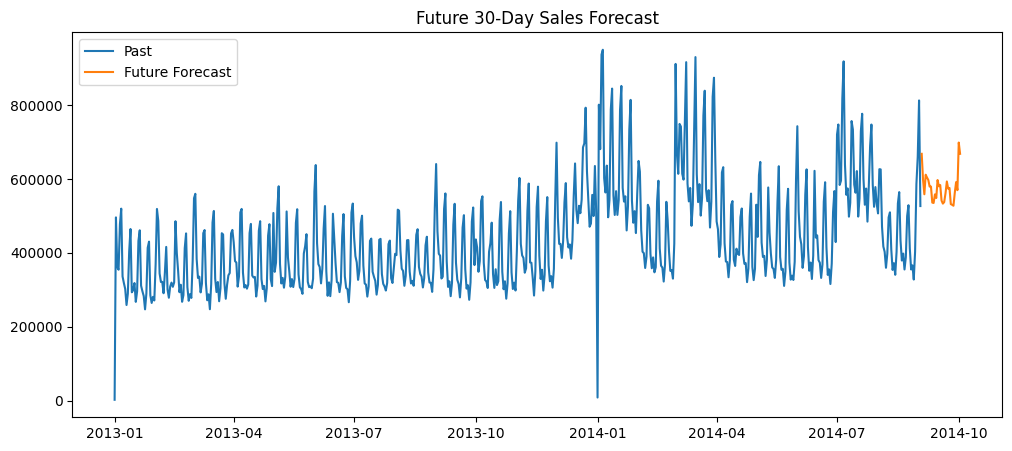

In [33]:
plt.figure(figsize=(12,5))
plt.plot(daily_feat['date'], daily_feat['sales'], label='Past')
plt.plot(future_df['date'], future_df['pred_sales'], label='Future Forecast')
plt.legend()
plt.title("Future 30-Day Sales Forecast")
plt.show()
